In [1]:
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import GRU, Activation, Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import datetime
import os

In [2]:
import pandas as pd
df = pd.read_csv('./data/Flotation_Plant_preprocessed.csv')

In [3]:
SPLITS = ['train', 'valid']
TIMESPLITS = {
    'train':{
        'start': datetime.datetime(2017,3,29,12,0,0),
        'end': datetime.datetime(2017,7,23,3,0,0)
    },
    'valid':{
        'start': datetime.datetime(2017,7,23,3,0,0),
        'end': datetime.datetime(2017,9,9,23,0,0)}
    }

In [4]:
df['datetime'] = pd.to_datetime(df.datetime)
# drop date column
df = df.drop('date', axis=1)

filter = {split: (df['datetime'] >= TIMESPLITS[split]['start']) & 
            (df['datetime'] < TIMESPLITS[split]['end']) &
            (df['datetime'].dt.second == 0) & 
            (df['datetime'].dt.minute == 0) for split in SPLITS}

dfs = {split: df.loc[filter[split]] for split in SPLITS}

        
for split in SPLITS:
    dfs[split] = dfs[split].drop('datetime', axis=1)
    dfs[split] = dfs[split].drop('% Iron Concentrate', axis=1)
    dfs[split].to_csv('./data/'+split+'.csv', index=False)

In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/valid.csv')

In [6]:
min_max_dict = {}
for col in df_train.columns:
    if col not in ['% Silica Concentrate']:
        min_max_dict[col] = [df_train[col].min(), df_train[col].max()]

In [7]:
# train scale
train_scale = pd.DataFrame()
for col in df_train.columns:
    if col not in ['% Silica Concentrate']:
        train_scale[col] = (df_train[col] - min_max_dict[col][0])/(min_max_dict[col][1]-min_max_dict[col][0])
    else:
        train_scale[col] = df_train[col]

In [8]:
# train scale
test_scale = pd.DataFrame()
for col in df_test.columns:
    if col not in ['% Silica Concentrate']:
        test_scale[col] = (df_test[col] - min_max_dict[col][0])/(min_max_dict[col][1]-min_max_dict[col][0])
    else:
        test_scale[col] = df_test[col]

In [9]:
# predict next hour's % Silica Concentrate
Y_train = train_scale['% Silica Concentrate'].shift(periods=-1).iloc[:-1]
Y_test = test_scale['% Silica Concentrate'].shift(periods=-1).iloc[:-1]

In [46]:
train_scale.to_numpy().shape
#np.reshape(train_scale.to_numpy())

(2775, 22)

In [10]:
#training: reshape to get 6 rows as a batch
step = 6
x_numpy = []
y_numpy = []
for i in range(train_scale.shape[0]-step):
    tmp = train_scale.iloc[i:i+step]
    x_numpy.append(tmp.to_numpy())
    tmpy = Y_train.iloc[i+step-1]
    y_numpy.append(np.array([tmpy]))
x_numpy = np.array(x_numpy)
y_numpy = np.array(y_numpy)

In [11]:
#testing: reshape to get 6 rows as a batch
step = 6
x_numpy_test = []
y_numpy_test = []
for i in range(test_scale.shape[0]-step):
    tmp = test_scale.iloc[i:i+step]
    x_numpy_test.append(tmp.to_numpy())
    tmpy = Y_test.iloc[i+step-1]
    y_numpy_test.append(np.array([tmpy]))
x_numpy_test = np.array(x_numpy_test)
y_numpy_test = np.array(y_numpy_test)

In [12]:
print(x_numpy.shape)
print(y_numpy.shape)

(2769, 6, 22)
(2769, 1)


In [13]:
print(x_numpy_test.shape)
print(y_numpy_test.shape)

(1166, 6, 22)
(1166, 1)


# training

## model1
* 3 layers of LSTM + 1 Dropout
* small batch size
* loss early stop
----
* result: overfitting

In [94]:
# model
# Adding the first LSTM layer and some Dropout regularisation
regressor1 = Sequential()
regressor1.add(LSTM(units = 512, return_sequences = True,input_length=x_numpy.shape[1], input_dim=x_numpy.shape[2]))
#regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor1.add(LSTM(units = 512, return_sequences = True))
regressor1.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor1.add(LSTM(units = 512))
#regressor.add(Dropout(0.2))
regressor1.add(Dense(units = 1))

In [95]:
regressor1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 6, 512)            1095680   
                                                                 
 lstm_11 (LSTM)              (None, 6, 512)            2099200   
                                                                 
 dropout_6 (Dropout)         (None, 6, 512)            0         
                                                                 
 lstm_12 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 5,294,593
Trainable params: 5,294,593
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Compiling
callback = EarlyStopping(monitor='loss', patience=50)
regressor1.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')

# 進行訓練
regressor1.fit(x_numpy, y_numpy, epochs = 400, batch_size = 128, callbacks=[callback])

Epoch 1/400
22/22 [==============================] - 15s 432ms/step - loss: 2.2077
Epoch 2/400
22/22 [==============================] - 9s 426ms/step - loss: 0.9380
Epoch 3/400
22/22 [==============================] - 12s 535ms/step - loss: 0.7987
Epoch 4/400
22/22 [==============================] - 12s 528ms/step - loss: 0.7120
Epoch 5/400
22/22 [==============================] - 11s 487ms/step - loss: 0.5885
Epoch 6/400
22/22 [==============================] - 11s 522ms/step - loss: 0.5130
Epoch 7/400
22/22 [==============================] - 10s 432ms/step - loss: 0.4987
Epoch 8/400
22/22 [==============================] - 9s 417ms/step - loss: 0.5253
Epoch 9/400
22/22 [==============================] - 9s 411ms/step - loss: 0.4918
Epoch 10/400
22/22 [==============================] - 9s 422ms/step - loss: 0.4857
Epoch 11/400
22/22 [==============================] - 9s 408ms/step - loss: 0.5131
Epoch 12/400
22/22 [==============================] - 9s 409ms/step - loss: 0.4840
Epoch 1

In [103]:
# training reslult
prob = regressor1.predict(x_numpy)

87/87 [==============================] - 8s 77ms/step


In [111]:
# mse, mape
print(mean_squared_error(y_numpy, prob))
print(mean_absolute_percentage_error(y_numpy, prob))

0.004185633842608395
0.02282727602861496


In [116]:
# testing reslult
prob_test = regressor1.predict(x_numpy_test)

37/37 [==============================] - 3s 77ms/step


In [117]:
# mse
print(mean_squared_error(y_numpy_test, prob_test))
print(mean_absolute_percentage_error(y_numpy_test, prob_test))

0.8125146323013113
0.305851111843165


## model2
* 3 layers of LSTM + 2 Dropout(add one more dropout)
* larger batch size
* loss early stop
----
* result: overfitting

In [16]:
# split valid: 10%
x_numpy_train = x_numpy[:2492]
y_numpy_train = y_numpy[:2492]
x_numpy_valid = x_numpy[2492:]
y_numpy_valid = y_numpy[2492:]

In [126]:
# model
# Adding the first LSTM layer and some Dropout regularisation
regressor2 = Sequential()
regressor2.add(LSTM(units = 512, return_sequences = True,input_length=x_numpy.shape[1], input_dim=x_numpy.shape[2]))
regressor2.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor2.add(LSTM(units = 512, return_sequences = True))
regressor2.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor2.add(LSTM(units = 512))
#regressor.add(Dropout(0.2))
regressor2.add(Dense(units = 1))

In [127]:
regressor2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 6, 512)            1095680   
                                                                 
 dropout_7 (Dropout)         (None, 6, 512)            0         
                                                                 
 lstm_14 (LSTM)              (None, 6, 512)            2099200   
                                                                 
 dropout_8 (Dropout)         (None, 6, 512)            0         
                                                                 
 lstm_15 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 5,294,593
Trainable params: 5,294,593
No

In [ ]:
# Compiling
callback = EarlyStopping(monitor='loss', patience=50)
regressor2.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')

# 進行訓練
regressor2.fit(x_numpy_train, y_numpy_train, epochs = 400, batch_size = 512, validation_data=(x_numpy_valid, y_numpy_valid), callbacks=[callback])

Epoch 1/400
5/5 [==============================] - 13s 2s/step - loss: 4.0126 - val_loss: 1.2622
Epoch 2/400
5/5 [==============================] - 6s 1s/step - loss: 3.1853 - val_loss: 1.1661
Epoch 3/400
5/5 [==============================] - 6s 1s/step - loss: 1.4699 - val_loss: 1.9214
Epoch 4/400
5/5 [==============================] - 6s 1s/step - loss: 1.1919 - val_loss: 0.6627
Epoch 5/400
5/5 [==============================] - 6s 1s/step - loss: 1.1327 - val_loss: 0.6779
Epoch 6/400
5/5 [==============================] - 6s 1s/step - loss: 0.9524 - val_loss: 0.9028
Epoch 7/400
5/5 [==============================] - 6s 1s/step - loss: 0.8898 - val_loss: 0.6541
Epoch 8/400
5/5 [==============================] - 6s 1s/step - loss: 0.8840 - val_loss: 0.7049
Epoch 9/400
5/5 [==============================] - 6s 1s/step - loss: 0.8591 - val_loss: 0.7053
Epoch 10/400
5/5 [==============================] - 6s 1s/step - loss: 0.8314 - val_loss: 0.6481
Epoch 11/400
5/5 [====================

## model 3
* 3 layers of LSTM + 1 Dropout
* larger batch size
* change to val_loss for early stop
----
* result: large bias on testing data

In [20]:
# model
# Adding the first LSTM layer and some Dropout regularisation
regressor3 = Sequential()
regressor3.add(LSTM(units = 512, return_sequences = True,input_length=x_numpy.shape[1], input_dim=x_numpy.shape[2]))
regressor3.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor3.add(LSTM(units = 512, return_sequences = True))
#regressor3.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor3.add(LSTM(units = 512))
regressor3.add(Dense(units = 1))

In [21]:
# Compiling
callback = EarlyStopping(monitor='val_loss', patience=50)
regressor3.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')

# 進行訓練
regressor3.fit(x_numpy_train, y_numpy_train, epochs = 300, batch_size = 512, validation_data=(x_numpy_valid, y_numpy_valid), callbacks=[callback])

Epoch 1/300
5/5 [==============================] - 13s 2s/step - loss: 2.7945 - val_loss: 0.7378
Epoch 2/300
5/5 [==============================] - 6s 1s/step - loss: 1.0920 - val_loss: 0.6407
Epoch 3/300
5/5 [==============================] - 6s 1s/step - loss: 0.9099 - val_loss: 0.7101
Epoch 4/300
5/5 [==============================] - 6s 1s/step - loss: 0.8211 - val_loss: 0.6550
Epoch 5/300
5/5 [==============================] - 7s 1s/step - loss: 0.8081 - val_loss: 0.6121
Epoch 6/300
5/5 [==============================] - 6s 1s/step - loss: 0.7692 - val_loss: 0.6582
Epoch 7/300
5/5 [==============================] - 6s 1s/step - loss: 0.7349 - val_loss: 0.6751
Epoch 8/300
5/5 [==============================] - 6s 1s/step - loss: 0.7039 - val_loss: 0.6370
Epoch 9/300
5/5 [==============================] - 6s 1s/step - loss: 0.6822 - val_loss: 0.6562
Epoch 10/300
5/5 [==============================] - 6s 1s/step - loss: 0.6183 - val_loss: 0.6200
Epoch 11/300
5/5 [====================

In [22]:
# testing reslult
prob_test = regressor3.predict(x_numpy_test)

37/37 [==============================] - 4s 77ms/step


In [23]:
# mse
print(mean_squared_error(y_numpy_test, prob_test))
print(mean_absolute_percentage_error(y_numpy_test, prob_test))

0.6292300269750448
0.2776330160034336


## model 4
* 3 layers of LSTM + 1 Dropout
* larger batch size
* val_loss for early stop
* larger training data
----
* result: mse decreased 24%

In [24]:
# model
# Adding the first LSTM layer and some Dropout regularisation
regressor4 = Sequential()
regressor4.add(LSTM(units = 512, return_sequences = True,input_length=x_numpy.shape[1], input_dim=x_numpy.shape[2]))
regressor4.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor4.add(LSTM(units = 512, return_sequences = True))
#regressor3.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor4.add(LSTM(units = 512))
regressor4.add(Dense(units = 1))

In [25]:
# Compiling
callback = EarlyStopping(monitor='val_loss', patience=50)
regressor4.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')

# 進行訓練
regressor4.fit(x_numpy, y_numpy, epochs = 300, batch_size = 512, validation_data=(x_numpy_test, y_numpy_test), callbacks=[callback])

Epoch 1/300
6/6 [==============================] - 15s 2s/step - loss: 4.6098 - val_loss: 3.9218
Epoch 2/300
6/6 [==============================] - 8s 1s/step - loss: 3.9545 - val_loss: 2.5666
Epoch 3/300
6/6 [==============================] - 8s 1s/step - loss: 1.5906 - val_loss: 1.3372
Epoch 4/300
6/6 [==============================] - 8s 1s/step - loss: 1.1337 - val_loss: 1.3387
Epoch 5/300
6/6 [==============================] - 8s 1s/step - loss: 1.0268 - val_loss: 1.0086
Epoch 6/300
6/6 [==============================] - 8s 1s/step - loss: 0.9397 - val_loss: 0.9411
Epoch 7/300
6/6 [==============================] - 8s 1s/step - loss: 0.8761 - val_loss: 0.8882
Epoch 8/300
6/6 [==============================] - 8s 1s/step - loss: 0.8426 - val_loss: 0.8683
Epoch 9/300
6/6 [==============================] - 8s 1s/step - loss: 0.8255 - val_loss: 0.8794
Epoch 10/300
6/6 [==============================] - 8s 1s/step - loss: 0.8022 - val_loss: 0.8333
Epoch 11/300
6/6 [====================

In [29]:
# mse
# testing reslult
prob_test = regressor4.predict(x_numpy_test)
print(mean_squared_error(y_numpy_test, prob_test))
print(mean_absolute_percentage_error(y_numpy_test, prob_test))

37/37 [==============================] - 4s 84ms/step
0.471245270749588
0.2324831435157915


In [33]:
y_numpy_test.shape

(1166, 1)

<AxesSubplot: >

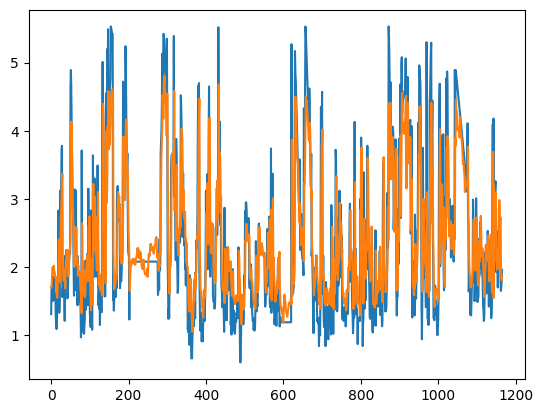

In [34]:
import seaborn as sns
sns.lineplot(data = y_numpy_test.reshape(1166,))
sns.lineplot(data = prob_test.reshape(1166,))

## model5
* 3 layers of GRU + 1 Dropout(change LSTM to GRU)
* larger batch size
* val_loss for early stop
----
* result: similar to model 4, but smaller mape

In [36]:
# model
# Adding the first LSTM layer and some Dropout regularisation
regressor5 = Sequential()
regressor5.add(GRU(units = 512, return_sequences = True,input_length=x_numpy.shape[1], input_dim=x_numpy.shape[2]))
regressor5.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor5.add(GRU(units = 512, return_sequences = True))
#regressor3.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor5.add(GRU(units = 512))
regressor5.add(Dense(units = 1))

In [37]:
regressor5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 6, 512)            823296    
                                                                 
 dropout_2 (Dropout)         (None, 6, 512)            0         
                                                                 
 gru_4 (GRU)                 (None, 6, 512)            1575936   
                                                                 
 gru_5 (GRU)                 (None, 512)               1575936   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,975,681
Trainable params: 3,975,681
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compiling
callback = EarlyStopping(monitor='val_loss', patience=50)
regressor5.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')

# 進行訓練
regressor5.fit(x_numpy, y_numpy, epochs = 300, batch_size = 512, validation_data=(x_numpy_test, y_numpy_test), callbacks=[callback])

Epoch 1/300
6/6 [==============================] - 14s 1s/step - loss: 3.2173 - val_loss: 1.0027
Epoch 2/300
6/6 [==============================] - 6s 1s/step - loss: 0.9574 - val_loss: 0.9491
Epoch 3/300
6/6 [==============================] - 6s 1s/step - loss: 0.8303 - val_loss: 0.7663
Epoch 4/300
6/6 [==============================] - 6s 1s/step - loss: 0.7140 - val_loss: 0.7978
Epoch 5/300
6/6 [==============================] - 7s 1s/step - loss: 0.6553 - val_loss: 0.5946
Epoch 6/300
6/6 [==============================] - 6s 1s/step - loss: 0.5774 - val_loss: 0.5797
Epoch 7/300
6/6 [==============================] - 6s 1s/step - loss: 0.5348 - val_loss: 0.5057
Epoch 8/300
6/6 [==============================] - 6s 1s/step - loss: 0.5014 - val_loss: 0.4769
Epoch 9/300
6/6 [==============================] - 6s 1s/step - loss: 0.4864 - val_loss: 0.4679
Epoch 10/300
6/6 [==============================] - 6s 1s/step - loss: 0.4779 - val_loss: 0.4579
Epoch 11/300
6/6 [====================

In [39]:
# mse
# testing reslult
prob_test = regressor5.predict(x_numpy_test)
print(mean_squared_error(y_numpy_test, prob_test))
print(mean_absolute_percentage_error(y_numpy_test, prob_test))

37/37 [==============================] - 3s 63ms/step
0.4767729060422795
0.20374669069778026


<AxesSubplot: >

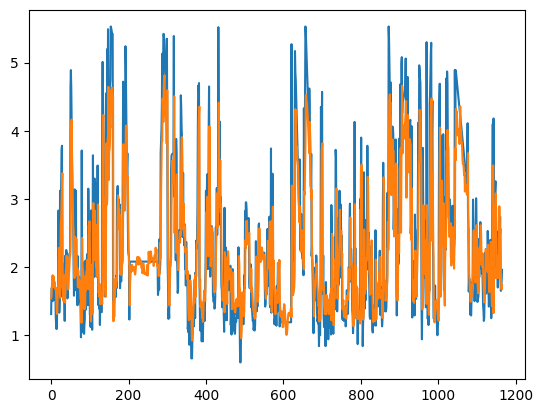

In [40]:
import seaborn as sns
sns.lineplot(data = y_numpy_test.reshape(1166,))
sns.lineplot(data = prob_test.reshape(1166,))

In [43]:
prob = regressor5.predict(x_numpy)

87/87 [==============================] - 6s 64ms/step


In [49]:
prob = prob.reshape(prob.shape[0],)
prob_test = prob_test.reshape(prob_test.shape[0],)
y_numpy_test_list = y_numpy_test.reshape(y_numpy_test.shape[0],)
y_numpy_list = y_numpy.reshape(y_numpy.shape[0],)

In [55]:
df_train_result = pd.DataFrame(data={'label':y_numpy_list, 'prediction':prob})
df_valid_result = pd.DataFrame(data={'label':y_numpy_test_list, 'prediction':prob_test})

In [56]:
df_train_result.to_csv('./result/train_label.csv')
df_valid_result.to_csv('./result/valid_label.csv')